In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import tarfile
import community
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from clustering import *

In [2]:
tar_file_path = 'data/period_data.tar'

period_data = load_data(tar_file_path)

In [12]:
after_15_30 = period_data.copy()
after_15_30 = after_15_30.pivot_table(index='xltime', columns='stock', values='price', aggfunc='mean')
after_15_30.index = pd.to_datetime(after_15_30.index)
after_15_30 = after_15_30[after_15_30.index.time >= datetime.strptime('15:30', '%H:%M').time()]

after_15_30

stock,CORN,CPER,DBC,EDEN,EFNL,EIS,EUSA,EWA,EWC,EWD,...,WEAT,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
xltime,,,,,,,,,,,,,,,,,,,,,
2012-03-01 15:30:00-05:00,41.033056,27.770960,29.832446,NaN,NaN,40.948824,29.656403,23.915227,29.306671,29.565486,...,NaN,37.362520,75.544803,14.894215,37.315204,29.090772,33.124608,34.901217,36.343785,43.480585
2012-03-01 15:31:00-05:00,41.017398,27.733922,29.842285,NaN,NaN,40.956000,29.641789,23.914424,29.302070,29.566527,...,NaN,37.353526,75.537508,14.892514,37.302899,29.080492,33.125699,34.903048,36.334793,43.474528
2012-03-01 15:32:00-05:00,41.015000,NaN,29.837190,NaN,NaN,40.953614,29.630391,23.893736,29.291755,29.546538,...,NaN,37.349301,75.493080,14.886596,37.282500,29.063336,33.125541,34.892732,36.323034,43.452650
2012-03-01 15:33:00-05:00,41.034524,NaN,29.841112,NaN,NaN,40.954885,29.624704,23.891378,29.290477,29.549722,...,NaN,37.342737,75.449532,14.882629,37.284003,29.055546,33.121034,34.885636,36.326393,43.445390
2012-03-01 15:34:00-05:00,NaN,NaN,29.847432,NaN,NaN,40.984286,29.604700,23.883197,29.288573,29.544439,...,NaN,37.322275,75.442049,14.875168,37.282409,29.043156,33.113613,34.875502,36.322117,43.434583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 15:55:00-05:00,44.306397,25.403571,27.759922,NaN,NaN,42.023646,30.643805,25.132337,28.437938,30.169319,...,21.319688,37.542730,71.363469,16.389956,37.890515,28.911507,34.857224,34.931154,39.897075,47.424936
2012-12-31 15:56:00-05:00,44.326222,25.396667,27.764300,31.852928,26.210588,42.035635,30.608323,25.108559,28.425477,30.149678,...,21.296429,37.514376,71.313814,16.378376,37.866717,28.889811,34.843864,34.915377,39.874200,47.392575
2012-12-31 15:57:00-05:00,44.326667,25.391667,27.765539,31.930000,26.069091,NaN,30.625325,25.095958,28.398757,30.139777,...,21.304027,37.482111,71.264554,16.368399,37.831159,28.857766,34.822122,34.878850,39.849054,47.360134


Processing tar file: data/period_data.tar
Combined DataFrame shape: (4033946, 7)
Daily data shape: (210, 19800)
There are 7 clusters
The length of each clusters are Cluster
0    20
1    18
2    29
3    78
4    62
5     1
6     2
dtype: int64
The clusters are:             Day  Cluster
0    2012-03-01        0
1    2012-03-02        1
2    2012-03-05        2
3    2012-03-06        3
4    2012-03-07        3
..          ...      ...
205  2012-12-24        4
206  2012-12-26        2
207  2012-12-27        4
208  2012-12-28        3
209  2012-12-31        2

[210 rows x 2 columns]


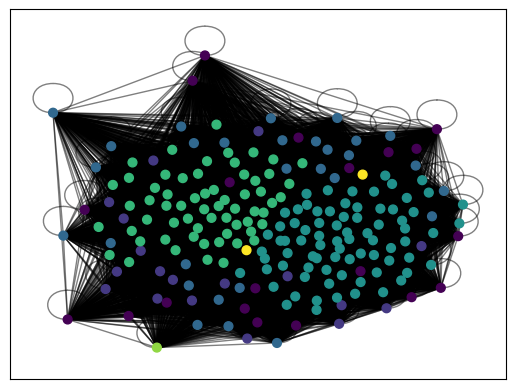

In [13]:
clusters = create_clusters(tar_file_path)